# Лабораторная работа №4 Метрические методы классификации                                                                                                           
## Сергеев Никита 
Вариант 16

### Цель работы

изучение принципов построения информационных систем с использованием метрических методов классификации.

### Задачи 

 - изучение инструментария Python для реализации алгоритмов метрической классификации;
 - изучение методов оптимизации параметров метрической классификации;
 - освоение модификаций kNN-метода.

## Ход работы:

### Загружаем набор данных

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
data_source = "./dataset/train.csv"
data = pd.read_csv(data_source, delimiter=',')
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Описание набора данных
Pclass — класс пассажира (1 — высший, 2 — средний, 3 — низший);

Name — имя;

Sex — пол;

Age — возраст;

SibSp — количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника;

Parch — количество родителей, детей (в том числе приемных) на борту титаника;

Ticket — номер билета;

Fare — плата за проезд;

Cabin — каюта;

Embarked — порт посадки (C — Шербур; Q — Квинстаун; S — Саутгемптон).

Прежде всего нам в столбце "Sex" нужно изменить строковые значения на числовые, чтобы мы могли их обрабатывать

In [9]:
data['Sex'] = data['Sex'].replace({'female': 0, 'male': 1})

## Визуализируем данные

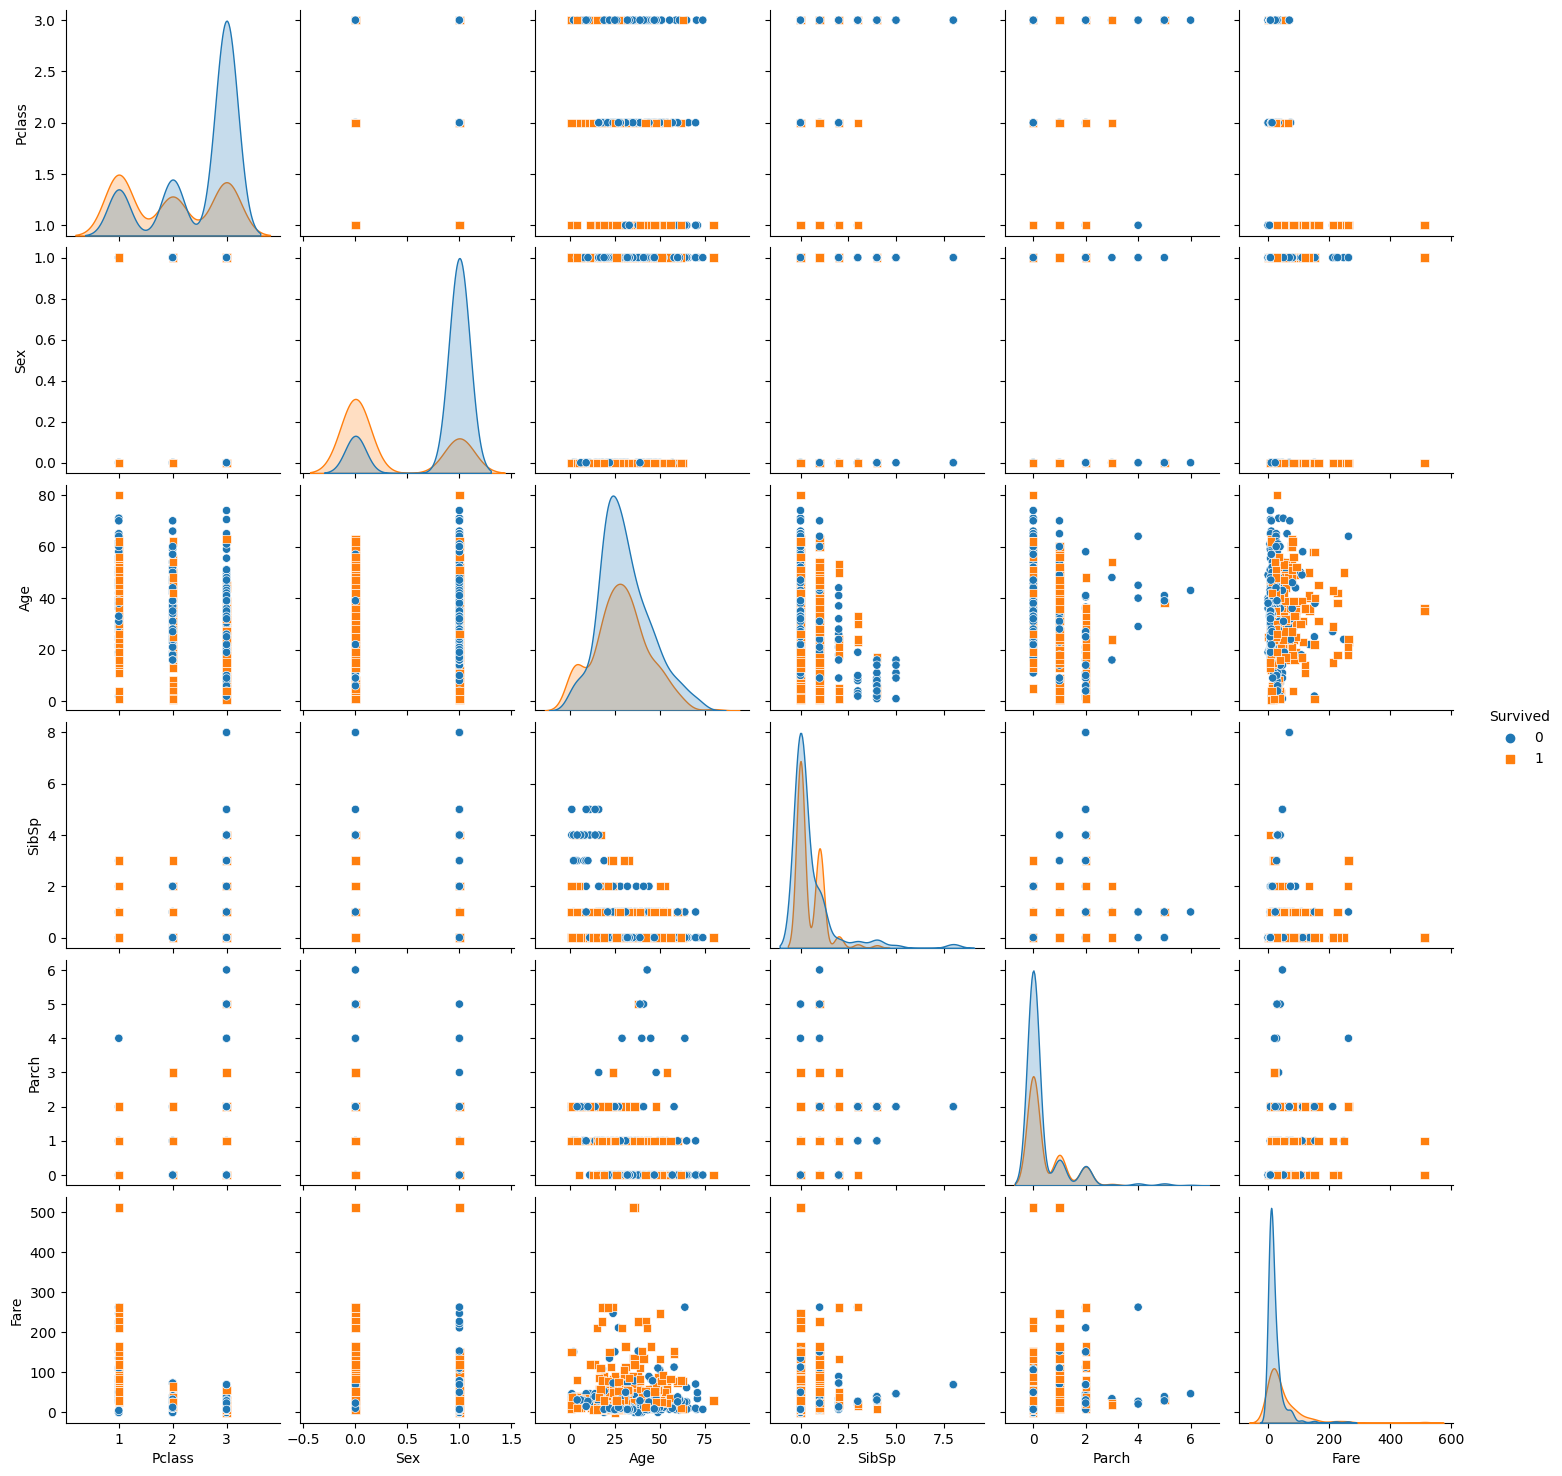

In [10]:
sns.pairplot(data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']], hue='Survived', markers=["o", "s"]);

Так как некоторые данные точно не вляют на результат, выберем только интересующие нас признаки
А также заполним пропуски в столбце Age на среднее значение возраста

In [11]:
mean_age = data['Age'].mean()
data['Age'].fillna(mean_age, inplace=True)
print(mean_age)

29.69911764705882


## Построим модель классификатора

In [12]:
from sklearn.neighbors import KNeighborsClassifier

X_train = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values
y_train = data['Survived'].values

K = 3 # Количество соседей

# Создание и настройка классификатора
knn = KNeighborsClassifier(n_neighbors=K)
# построение модели классификатора (процедура обучения)
knn.fit(X_train, y_train)

# Использование классификатора
# Объявление признаков объекта
X_new = np.array([[2, 1, 28, 1, 0, 20.0000]])
# Получение ответа для нового объекта
target = knn.predict(X_new)
print(target)

[0]


## Оценим точность

### Методом hold_out

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_holdout, y_train, y_holdout = train_test_split(
    data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']], 
    data['Survived'], 
    test_size=0.3, 
    random_state=17)

K = 3 # Количество соседей
knn = KNeighborsClassifier(n_neighbors=K)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_holdout)
accur = accuracy_score(y_holdout, knn_pred)
print('accuracy: ', accur)

accuracy:  0.7126865671641791


Здесь так же получилось самая высокая точность при количестве соседей равном 3

### Методом cross validation (CV) error

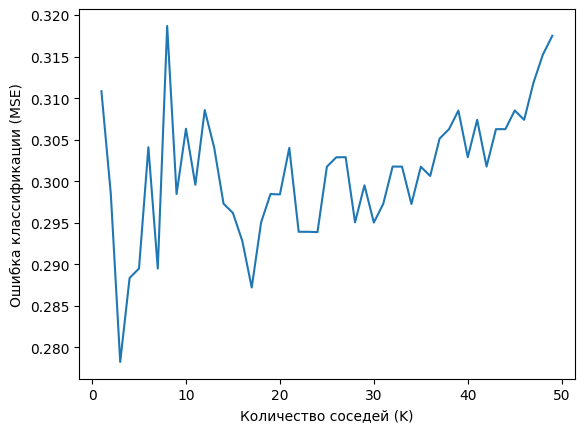

Оптимальные значения K:  [3]


In [14]:
# Реализация процедуры выбора оптимального параметра на основе cross validation error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Значения параметра K
k_list = list(range(1,50))
# Пустой список для хранения значений точности
cv_scores = []
# В цикле проходим все значения K
for K in k_list:
    knn = KNeighborsClassifier(n_neighbors=K)
    scores = cross_val_score(
        knn, 
        data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']], 
        data['Survived'], 
        cv=10, 
        scoring='accuracy')
    cv_scores.append(scores.mean())

# Вычисляем ошибку (misclassification error)
MSE = [1-x for x in cv_scores]

# Строим график
plt.plot(k_list, MSE)
plt.xlabel('Количество соседей (K)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

# Ищем минимум
k_min = min(MSE)

# Пробуем найти прочие минимумы (если их несколько)
all_k_min = []
for i in range(len(MSE)):
    if MSE[i] <= k_min:
        all_k_min.append(k_list[i])

# печатаем все K, оптимальные для модели
print('Оптимальные значения K: ', all_k_min)

In [ ]:
# dt = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
# dX = dt.iloc[:,0:3]
# dy = data['Survived']

# plot_markers = ['r*', 'g^']
# answers = dy.unique()

# # Создаем подграфики для каждой пары признаков
# f, places = plt.subplots(3, 3, figsize=(12,12))

# fmin = dX.min()-0.5
# fmax = dX.max()+0.5
# plot_step = 0.02  

# # Обходим все subplot
# for i in range(0,3):
#     for j in range(0,3):

#         # Строим решающие границы 
#         if(i != j):
#             xx, yy = np.meshgrid(np.arange(fmin[i], fmax[i], plot_step),
#                                np.arange(fmin[j], fmax[j], plot_step))
#             model = KNeighborsClassifier(n_neighbors=3)
#             model.fit(dX.iloc[:, [i,j]].values, dy.values)
#             p = model.predict(np.c_[xx.ravel(), yy.ravel()])
#             p = p.reshape(xx.shape)
#             places[i,j].contourf(xx, yy, p, cmap='Pastel1') 
      
#         # Обход всех классов
#         for id_answer in range(len(answers)):
#             idx = np.where(dy == answers[id_answer])
#             if i==j:
#                 places[i, j].hist(dX.iloc[idx].iloc[:,i],
#                                   color=plot_markers[id_answer][0],
#                                  histtype = 'step')
#             else:
#                 places[i, j].plot(dX.iloc[idx].iloc[:,i], dX.iloc[idx].iloc[:,j], 
#                                   plot_markers[id_answer], 
#                                   label=answers[id_answer], markersize=6)
        
#         if j==0:
#             places[i, j].set_ylabel(dX.columns[i])
        
#         if i==3:
#             places[i, j].set_xlabel(dX.columns[j])       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


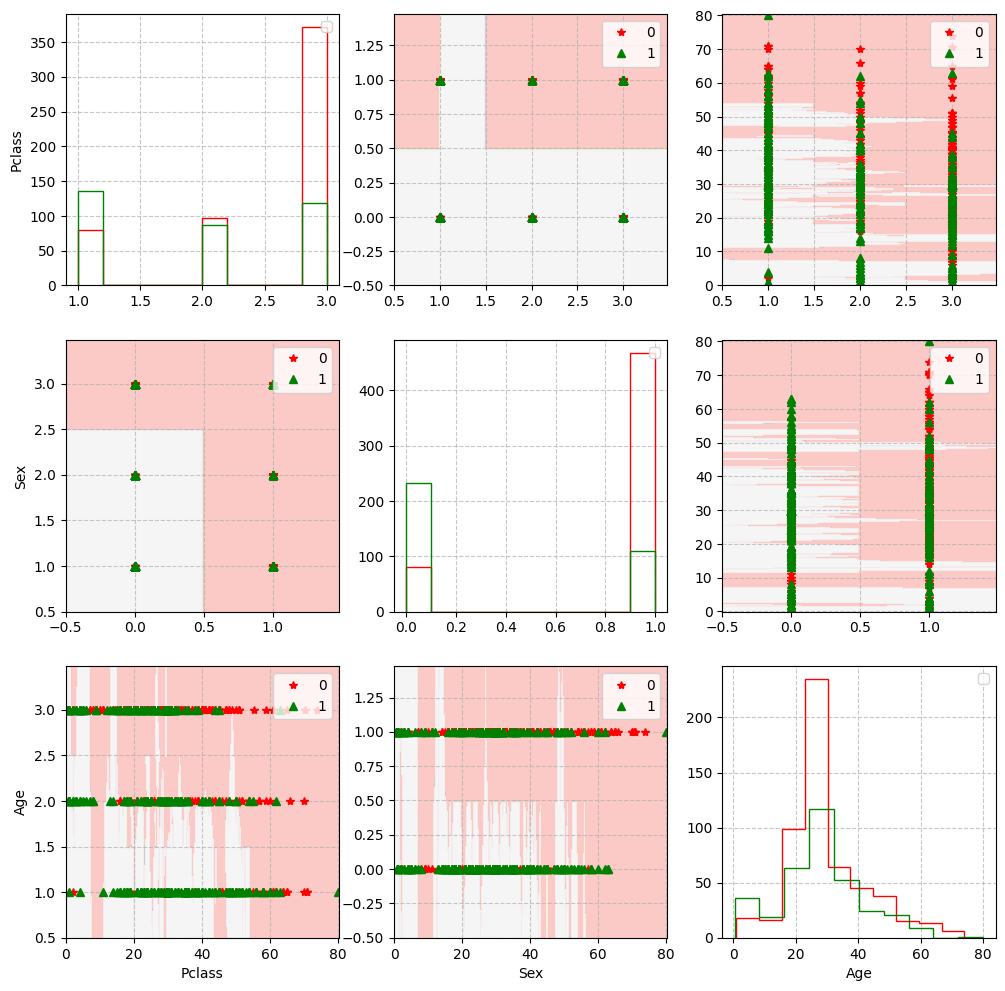

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

dt = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
dt = dt.iloc[:,0:3]
dy = data['Survived']

plot_markers = ['r*', 'g^']
answers = dy.unique()

f, places = plt.subplots(3, 3, figsize=(12, 12))

fmin = dt.min() - 0.5
fmax = dt.max() + 0.5
plot_step = 0.02  

for i in range(3):
    for j in range(3):
        if i != j:
            xx, yy = np.meshgrid(np.arange(fmin.iloc[i], fmax.iloc[i], plot_step),
                               np.arange(fmin.iloc[j], fmax.iloc[j], plot_step))
            model = KNeighborsClassifier(n_neighbors=13)
            model.fit(dt.iloc[:, [i, j]].values, dy.values)
            p = model.predict(np.c_[xx.ravel(), yy.ravel()])
            p = p.reshape(xx.shape)
            places[i, j].contourf(xx, yy, p, cmap='Pastel1', alpha=0.7)
      
        for id_answer in range(len(answers)):
            idx = np.where(dy == answers[id_answer])
            if i == j:
                places[i, j].hist(dt.iloc[idx].iloc[:, i],
                                  color=plot_markers[id_answer][0],
                                  histtype='step')
            else:
                places[i, j].plot(dt.iloc[idx].iloc[:, i], dt.iloc[idx].iloc[:, j], 
                                  plot_markers[id_answer], 
                                  label=answers[id_answer], markersize=6)
        
        if j == 0:
            places[i, j].set_ylabel(dt.columns[i])
        
        if i == 2:
            places[i, j].set_xlabel(dt.columns[j])

for i in range(3):
    for j in range(3):
        places[i, j].legend(loc='upper right')
        places[i, j].grid(linestyle='--', alpha=0.7)

plt.show()


### Использование модели

In [29]:
from sklearn.neighbors import KNeighborsClassifier

X_train = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values
y_train = data['Survived'].values

K = 3 # Найденное оптимальное значение соседей

# Создание и настройка классификатора
knn = KNeighborsClassifier(n_neighbors=K)
# построение модели классификатора (процедура обучения)
knn.fit(X_train, y_train)

# Использование классификатора
# Объявление признаков объекта

Pclass = float(input('Введите класс пассажира (1 — высший, 2 — средний, 3 — низший): '))
Sex = float(input('Введите пол пассажира (1 - мужчина, 0 - женщина): '))
Age = float(input('Введите возраст пассажира: '))
SibSp = float(input('Введите количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника: '))
Parch = float(input('Введите количество родителей, детей (в том числе приемных) на борту титаника: '))
Fare = float(input('Введите плату за проезд: '))

X_new = np.array([[Pclass, Sex, Age, SibSp, Parch, Fare]])

# Получение ответа для нового объекта
target = knn.predict(X_new)

if target == 0:
    iris_type = 'погиб'
elif target == 1:
    iris_type = 'выжил'

print('\nПассажир вероятнее всего', iris_type)

Введите класс пассажира (1 — высший, 2 — средний, 3 — низший):  3
Введите пол пассажира (1 - мужчина, 0 - женщина):  0
Введите возраст пассажира:  8
Введите количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника:  5
Введите количество родителей, детей (в том числе приемных) на борту титаника:  3
Введите плату за проезд:  1000.0000



Пассажир вероятнее всего выжил


## Контрольные вопросы

1. Поясните особенности основных методов метрической классификации: метод ближайшего соседа, метод k ближайших соседей.

Основные методы метрической классификации, такие как метод ближайшего соседа (1-NN) и метод k ближайших соседей (k-NN), основаны на идее определения класса объекта на основе его ближайших соседей в признаковом пространстве. Вот их основные особенности:

1. **Метод ближайшего соседа (1-NN):**
   - Для каждого объекта классификации он находит ближайшего соседа в тренировочном наборе данных, используя какую-либо метрику расстояния, обычно евклидово расстояние.
   - Классификация объекта происходит путем присвоения ему класса его ближайшего соседа.
   - 1-NN склонен к переобучению и может быть шумочувствительным, так как он смотрит только на одного ближайшего соседа.

2. **Метод k ближайших соседей (k-NN):**
   - В отличие от 1-NN, k-NN находит k ближайших соседей объекта, где k - это заданное число соседей.
   - Объекту присваивается класс, который наиболее часто встречается среди его k ближайших соседей.
   - Выбор k влияет на гладкость границ решений: маленькое k приводит к сложным границам, большое k приводит к более гладким границам.
   - k-NN менее склонен к переобучению по сравнению с 1-NN, но может быть чувствительным к выбору k и масштабу признаков.

Особенности и недостатки методов метрической классификации:
- Простота и интуитивность: Метрические методы просты в понимании и реализации.
- Не требуется предварительная обработка данных: Метрические методы не требуют предварительной нормализации данных и могут работать с различными типами признаков.
- Но они могут быть вычислительно затратными для больших наборов данных, так как требуется вычисление расстояний для каждой пары объектов.
- Чувствительность к выбору метрики: Результаты могут сильно зависеть от выбора метрики расстояния.
- Не учитывают внутреннюю структуру данных: Метрические методы не учитывают скрытую структуру данных, и их производительность может быть низкой в некоторых случаях.

Итак, методы метрической классификации, такие как 1-NN и k-NN, подходят для небольших и средних наборов данных, где они могут обеспечить хорошую производительность при правильном выборе гиперпараметров и метрик расстояния.

2. Поясните основные принципы и этапы реализации метода kNN.

Метод k-ближайших соседей (k-NN) - это простой алгоритм классификации, который классифицирует объекты на основе классов их k ближайших соседей в признаковом пространстве. Вот основные принципы и этапы реализации метода k-NN:

**Принципы:**

1. **Локальность:** Гипотеза локальности состоит в том, что близкие объекты в признаковом пространстве имеют схожие классы. Это предположение лежит в основе метода k-NN.

2. **Метрика расстояния:** Для определения ближайших соседей необходимо выбрать метрику расстояния, такую как евклидово расстояние, манхэттенское расстояние и другие. Метрика расстояния используется для измерения сходства между объектами.

**Этапы реализации метода k-NN:**

1. **Загрузка и предобработка данных:** Сначала загружаются и подготавливаются данные для обучения и тестирования. Это включает в себя разделение данных на обучающий и тестовый наборы.

2. **Выбор метрики расстояния:** Выберите метрику расстояния, которая будет использоваться для измерения расстояния между объектами в признаковом пространстве. Наиболее распространенной метрикой является евклидово расстояние.

3. **Выбор числа соседей (k):** Выберите количество ближайших соседей (k), которые будут использоваться для классификации объекта. Значение k должно быть выбрано внимательно, так как оно может влиять на результаты классификации.

4. **Вычисление расстояний:** Для каждого объекта тестового набора данных вычисляются расстояния до всех объектов обучающего набора данных с использованием выбранной метрики расстояния.

5. **Нахождение k ближайших соседей:** Для каждого объекта тестового набора данных выбираются k объектов обучающего набора данных с наименьшими расстояниями.

6. **Классификация:** Для каждого объекта тестового набора данных определяется класс, который наиболее часто встречается среди его k ближайших соседей. Этот класс присваивается объекту.

7. **Оценка производительности:** После классификации всех объектов тестового набора данных оценивается производительность метода k-NN, например, с использованием метрик точности, полноты, F1-меры и других.

8. **Выбор оптимальных параметров:** Можно выполнять подбор параметров, таких как метрика расстояния и значение k, для оптимизации производительности метода.

Метод k-NN - это относительно простой метод, который может быть эффективным для задач классификации, особенно в случаях, когда данные имеют локальную структуру. Однако для его эффективной работы необходимо правильно настроить параметры и подготовить данные.

3. Поясните принцип выбора количества соседних объектов, по которым определяется принадлежность целевого объекта к результирующему классу.

Выбор количества соседних объектов (k) в методе k-ближайших соседей (k-NN) важен и влияет на производительность алгоритма. Принцип выбора значения k определяет, сколько соседних объектов будет учтено при классификации целевого объекта. Вот некоторые ключевые моменты, которые следует учитывать при выборе значения k:

1. **Маленькое k (k = 1):**
   - Если k слишком маленькое, например, k = 1, то классификация будет сильно зависеть от одного ближайшего соседа.
   - Это может привести к шуму и нестабильным результатам, особенно если в данных есть выбросы или неточности.
   - Маленькое k может привести к сложным, нерегулярным границам решений.

2. **Среднее k:**
   - Обычно выбирают средние значения k, например, k = 3, 5 или 10.
   - Средние значения k обычно более устойчивы и менее склонны к переобучению по сравнению с маленькими k.
   - Они могут обеспечивать хороший баланс между сглаженными границами решений и точностью классификации.

3. **Большое k:**
   - Если k слишком большое, например, k равно размеру обучающей выборки, то классификация будет скорее всего соответствовать наиболее популярному классу в обучающей выборке.
   - Это может привести к сглаженным, гладким границам решений, но может упустить детали и разделение классов.

Процесс выбора значения k обычно включает в себя эксперименты и валидацию, например, кросс-валидацию. Вам нужно выбрать значение k, которое обеспечивает наилучшую производительность на ваших данных. Оптимальное значение k может зависеть от конкретной задачи, структуры данных и количества доступных обучающих данных.

Важно помнить, что выбор k - это компромисс между сглаженностью границ решений и точностью классификации, и нет универсального значения k, которое подходило бы для всех задач.

4. В чем заключается метод парзеновского окна?

Метод парзеновского окна (Parzen Window) - это один из методов, используемых для оценки плотности вероятности объектов в многомерных пространствах. Он играет важную роль в различных статистических задачах, включая классификацию, кластеризацию и оценку плотности вероятности. Основная идея метода парзеновского окна заключается в том, что объекту присваивается плотность вероятности, основанная на "окне" или "ядерной функции", которая центрируется на этом объекте и оценивается с использованием соседних объектов.

Вот основные принципы метода парзеновского окна:

1. **Окно и ядерная функция:** Перед использованием метода парзеновского окна нужно выбрать ядерную функцию и размер окна. Ядерная функция определяет, как вес объектов убывает с расстоянием от целевого объекта, а размер окна определяет, сколько ближайших соседей будут учтены.

2. **Ядерная функция:** Обычно в качестве ядерной функции используется гауссово ядро (гауссиана), которое имеет плотность вероятности, аналогичную нормальному распределению.

3. **Оценка плотности вероятности:** Для каждого объекта оценка плотности вероятности вычисляется как взвешенная сумма ядерных функций для всех соседей.

4. **Классификация или оценка плотности вероятности:** В задачах классификации метод парзеновского окна может использоваться для оценки плотности вероятности объектов в разных классах. Объекту присваивается класс, который имеет наибольшую оценку плотности вероятности. В задачах оценки плотности вероятности метод может использоваться для аппроксимации плотности данных в заданной области пространства.

Метод парзеновского окна обладает гибкостью и может адаптироваться к различным формам данных. Однако он может быть вычислительно затратным, особенно в многомерных пространствах, и требует настройки параметров, таких как размер окна \(h\) и выбор ядерной функции.

5. Назовите, какие параметры оптимизируют в методах kNN?

В методах k-ближайших соседей (k-NN) следующие параметры обычно оптимизируют:

1. **Количество ближайших соседей (k):** Один из самых важных параметров k-NN. Выбор оптимального значения k может значительно повлиять на производительность алгоритма. Слишком маленькое k может привести к переобучению, а слишком большое k может привести к сглаженным границам решений. Количество ближайших соседей обычно подбирают с помощью кросс-валидации.

2. **Метрика расстояния:** Выбор подходящей метрики расстояния (например, евклидово расстояние, манхэттенское расстояние, косинусное расстояние и др.) может быть важным для оптимальной работы алгоритма в зависимости от типа данных и задачи.

3. **Веса соседей:** В некоторых вариантах k-NN можно вводить веса для соседей в зависимости от их расстояния до целевого объекта. Ближайшие соседи могут иметь больший вес в прогнозировании, чем более далекие.

4. **Параметры ядра и окна (если используется метод парзеновского окна):** Если вы используете метод парзеновского окна для оценки плотности вероятности, вам придется выбирать параметры ядра (например, гауссово ядро) и размер окна (ширина ядерной функции).

5. **Обработка данных:** Вы также можете оптимизировать методы предварительной обработки данных, такие как нормализация или стандартизация, чтобы улучшить производительность k-NN.

6. **Выбор признаков:** Важно выбирать подходящие признаки и исключать ненужные, чтобы уменьшить размерность данных и снизить вычислительную нагрузку.

В зависимости от конкретной задачи и типа данных, параметры могут быть настроены с использованием методов оптимизации, а также путем применения кросс-валидации для оценки производительности модели с разными значениями параметров.